In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

In [3]:
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

In [5]:
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [6]:
import pickle
import gzip

In [7]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [8]:
import numpy as np
import matplotlib.pyplot as plt

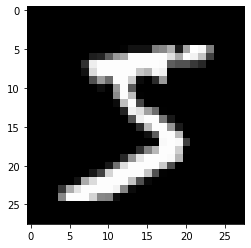

In [9]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [10]:
# black regions formed by the group of pixels of values equal to 0..where white regions is formed by the group of pixels of values 1.

In [11]:
import torch

In [12]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [13]:
n, c = x_train.shape

In [14]:
print(x_train.shape)
print(y_train.shape)
print(n)
print(c)

torch.Size([50000, 784])
torch.Size([50000])
50000
784


### Using torch.nn.functional

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.

In [15]:
import torch.nn.functional as F

In [16]:
loss_func = F.cross_entropy

In [17]:
print(loss_func)

<function cross_entropy at 0x7f0a3ac77d30>


In [18]:
def model(x):
    return x @ weights + bias

In [19]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [20]:
print(weights.shape)

torch.Size([784, 10])


In [21]:
print(bias.shape)

torch.Size([10])


In [22]:
bs = 64  # batch size
xb = x_train[0:bs]  # a mini-batch from x

In [23]:
print(xb.shape)

torch.Size([64, 784])


In [24]:
yb = y_train[0:bs]

In [25]:
print(yb.shape)

torch.Size([64])


In [26]:
y_pred = model(xb)

In [27]:
print(y_pred.shape)

torch.Size([64, 10])


In [28]:
print(y_pred[0])

tensor([-0.3082, -0.1130, -0.4908, -0.1565, -0.7198,  0.1920, -0.1104,  0.1640,
         0.2084,  0.2230], grad_fn=<SelectBackward>)


In [29]:
loss = loss_func(y_pred, yb)

In [30]:
print(loss)

tensor(2.3825, grad_fn=<NllLossBackward>)


### Refactor using nn.Module

In [31]:
from torch import nn

In [32]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [33]:
model = Mnist_Logistic()

In [34]:
print(model)

Mnist_Logistic()


In [35]:
y_pred = model(xb)

In [36]:
print(y_pred.shape)

torch.Size([64, 10])


In [37]:
epochs = 2
lr = 0.0001
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()



In [38]:
fit()

### Refactor using nn.Linear

In [39]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10) # it contains 10 neurons

    def forward(self, xb):
        return self.linear(xb)

In [40]:
model = Mnist_Logistic()
y_pred = model(xb)

In [41]:
print(y_pred.shape)

torch.Size([64, 10])


In [42]:
print(loss_func(model(xb), yb))

tensor(2.3343, grad_fn=<NllLossBackward>)


In [43]:
fit()

In [44]:
print(loss_func(model(xb), yb))

tensor(2.1712, grad_fn=<NllLossBackward>)


### Refactor using optim

In [45]:
from torch import optim

In [46]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [47]:
model, opt = get_model()

In [48]:
print(loss_func(model(xb), yb))

tensor(2.2860, grad_fn=<NllLossBackward>)


In [49]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad() # (optim.zero_grad() resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)


### Refactor using Dataset

In [50]:
from torch.utils.data import TensorDataset

In [51]:
# Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice.

In [52]:
train_ds = TensorDataset(x_train, y_train)

In [53]:
print(train_ds)

### Refactor using DataLoader

Pytorch’s DataLoader is responsible for managing batches.

In [55]:
from torch.utils.data import DataLoader

In [56]:
train_dl = DataLoader(train_ds, batch_size=bs)

In [57]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [58]:
print(train_dl)

In [59]:
for input, label in train_dl:
    print(input.shape)
    print(label.shape)
    break

torch.Size([64, 784])
torch.Size([64])


(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [60]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(2.2227)
1 tensor(2.1435)


### Create fit() and get_data()

In [61]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [62]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [63]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


In [64]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.2351364837646486
1 2.1530234519958498


### Switch to CNN

In [65]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # reshape
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


In [66]:
lr = 0.1

In [67]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [68]:
print(model)

Mnist_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)


In [69]:
from torchsummary import torchsummary

In [71]:
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2             [-1, 16, 7, 7]           2,320
            Conv2d-3             [-1, 10, 4, 4]           1,450
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [72]:
fit(20, model, loss_func, opt, train_dl, valid_dl)

0 0.35124286534786225
1 0.25743090638816357
2 0.20114103767871858
3 0.1719443232983351
4 0.15628230538964272
5 0.1521350473612547
6 0.1494518860578537
7 0.13883771307766438
8 0.16042089157104492
9 0.12182590115666389
10 0.1293998857498169
11 0.14247380566596984
12 0.1242527057826519
13 0.11991660948991775
14 0.12905698021054268
15 0.12466427579522132
16 0.13306765308380128
17 0.11918401442170143
18 0.11304188569188119
19 0.1204628854483366


### Building a custom layer

In [73]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [74]:
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [75]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.3333231912970543
1 0.2638965572595596
